In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [4]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')
data.head()

,Map,Killer,Nb Finished generators,Nb Escaped Survivors,Comments,Nb Hatch escapes,Season,SBMM
0,BAP,Deathslinger,5,4,NaN,0,February,False
1,MCM,Cannibal,2,0,NaN,0,February,False
2,SH,Huntress,5,4,Farm,0,February,False
3,CF,Myers,3,0,Mori,0,February,False
4,AVW,Hillbilly,5,4,1 hatch,1,February,False


## Correlation study

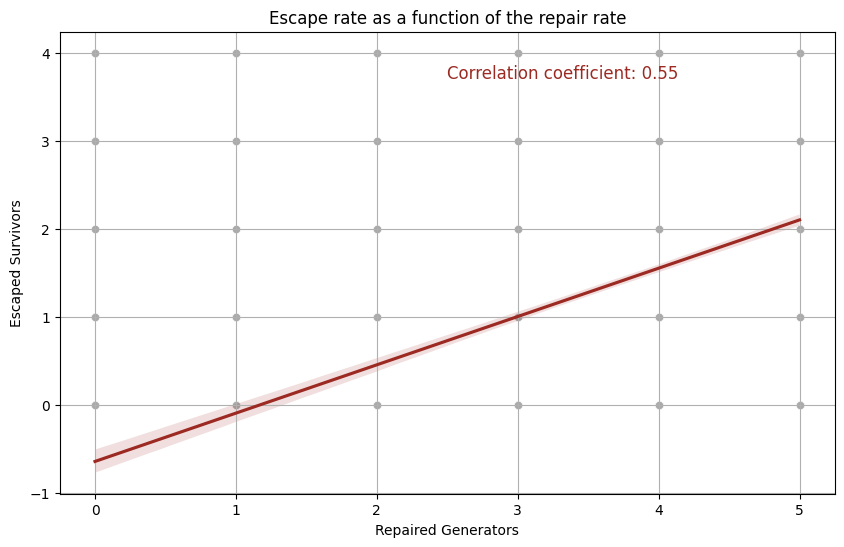

In [23]:
# Fit a linear regression model to get the slope
X = data['Nb Finished generators'].values.reshape(-1, 1)
y = data['Nb Escaped Survivors'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, color='darkgray')
sns.regplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, scatter=False, color='#9C2A23')

# Add grid
plt.grid(True)

# Add labels and title
plt.xlabel('Repaired Generators')
plt.ylabel('Escaped Survivors')
plt.title('Escape rate as a function of the repair rate')

# Annotate the plot with the slope value
plt.text(0.5, 0.9, f'Correlation coefficient: {slope:.2f}', transform=plt.gca().transAxes, fontsize=12, color='#9C2A23')

# Display the plot
plt.show()


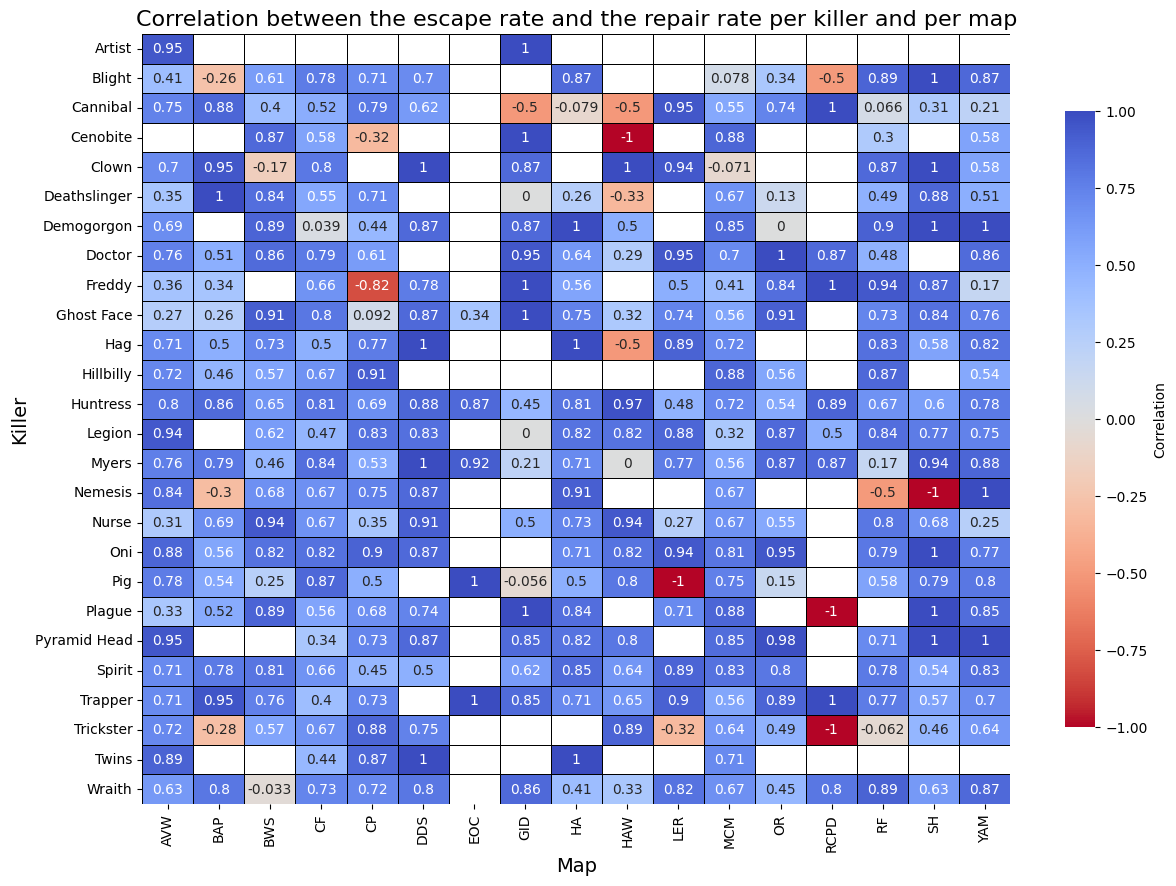

In [18]:
# Standardize the map names by stripping leading/trailing whitespace
data['Map'] = data['Map'].str.strip()

# Calculate Spearman correlation for each Killer and Map
cor_data = data.groupby(['Killer', 'Map']).apply(
    lambda group: pd.Series({
        'Correlation': group['Nb Finished generators'].corr(group['Nb Escaped Survivors'], method='spearman')
    })
).reset_index()

# Create a pivot table for the heatmap
cor_pivot = cor_data.pivot(index='Killer', columns='Map', values='Correlation')

# Plotting the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cor_pivot, annot=True, cmap='coolwarm_r', center=0, 
                 cbar_kws={'label': 'Correlation', 'orientation': 'vertical', 'shrink': 0.8},
                 linewidths=.5, linecolor='black')

# Customize the plot
ax.set_title('Correlation between the escape rate and the repair rate per killer and per map', fontsize=16)
ax.set_xlabel('Map', fontsize=14)
ax.set_ylabel('Killer', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add a grid
ax.set_yticks([i + 0.5 for i in range(len(cor_pivot))], minor=True)
ax.set_xticks([i + 0.5 for i in range(len(cor_pivot.columns))], minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Display the plot
plt.show()



## Escapes Prediction

### In this first attempt, we try to predict the escape rate of a given round, based on the Map, the Killer, as well as the number of generators repaired. We thus take into account escapes through the exit gates as well as well as hatch escapes (which do not depend on the number of generators repaired).

Accuracy: 0.4670138888888889
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping for this round: 0
Actual number of survivors escaping for this round: 1


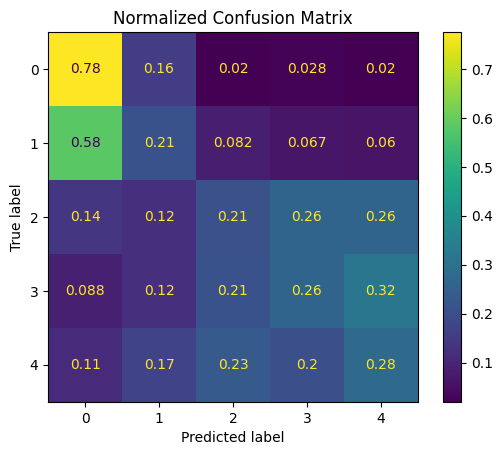

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       249
           1       0.30      0.21      0.25       134
           2       0.26      0.21      0.23        72
           3       0.24      0.26      0.25        57
           4       0.26      0.28      0.27        64

    accuracy                           0.47       576
   macro avg       0.34      0.35      0.34       576
weighted avg       0.44      0.47      0.45       576

In total 307 mistakes out of 576 samples


100%|██████████| 307/307 [00:00<00:00, 8537.50it/s]

Mistake 1:
Features: 
Map                           CP
Killer                    Spirit
Nb Finished generators         3
Name: 471, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 2:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 1
--------------------------------------------------
Mistake 5:
Features: 
Map                           OR
Killer                    Spirit
Nb Finished generat

In [14]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes', 'SBMM', 'Season'])
target = data['Nb Escaped Survivors']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_escapees = model.predict(example)
actual_escapees = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping for this round: {predicted_escapees[0]}')
print(f'Actual number of survivors escaping for this round: {actual_escapees}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gate Escapes (only!) Prediction

### Since hatch escapes do not depend on the number, we figure they might skew the data and 'confuse' the model. We thus choose to remove them from our predictions, and only predict the number of survivors who escaped through the exit gates.

Accuracy: 0.6180555555555556
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping through exit gates for this round: 0
Actual number of survivors escaping through exit gates for this round: 0


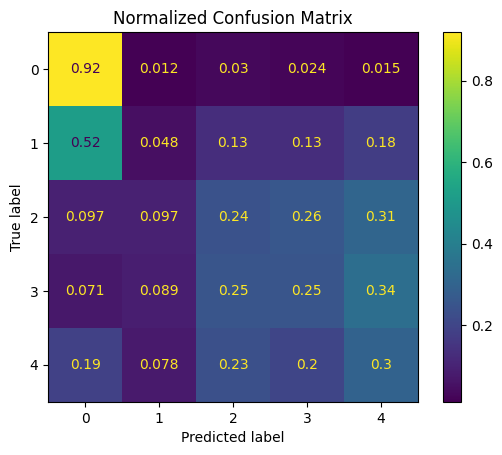

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       332
           1       0.13      0.05      0.07        62
           2       0.24      0.24      0.24        62
           3       0.24      0.25      0.24        56
           4       0.26      0.30      0.28        64

    accuracy                           0.62       576
   macro avg       0.34      0.35      0.34       576
weighted avg       0.58      0.62      0.60       576

In total 220 mistakes out of 576 samples


100%|██████████| 220/220 [00:00<00:00, 7616.69it/s]

Mistake 1:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 4:
Features: 
Map                          HAW
Killer                    Plague
Nb Finished generators         5
Name: 1800, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 5:
Features: 
Map                          GID
Killer                    Wraith
Nb Finished genera

In [15]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering (RF Classifier)

### In another attempt to improve our model, we also take into account the fact that when a Killer disconnects from the match, we count it as a 4-survivors escape into our dataset, which again skews the data as the number of generators repaired didn't play a role in this escape. We thus filter the data and remove all the entries where a Killer disconnect (indicated in the Comments by 'Killer DC')

Accuracy: 0.6336283185840708
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 4
Actual number of survivors escaping through exit gates for this round: 3


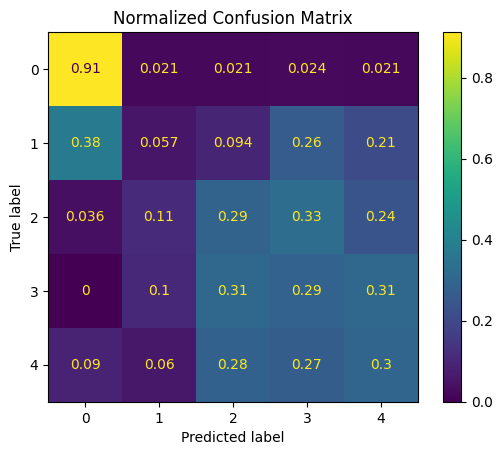

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       331
           1       0.12      0.06      0.08        53
           2       0.25      0.29      0.27        55
           3       0.23      0.29      0.25        59
           4       0.29      0.30      0.29        67

    accuracy                           0.63       565
   macro avg       0.36      0.37      0.36       565
weighted avg       0.63      0.63      0.63       565

In total 207 mistakes out of 565 samples


100%|██████████| 207/207 [00:00<00:00, 4688.55it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [7]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_classifier.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


With grid search

### How to improve grid search??

Accuracy: 0.6460176991150443
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3


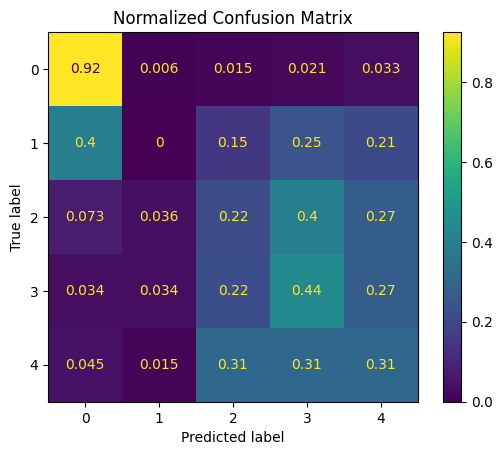

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       331
           1       0.00      0.00      0.00        53
           2       0.20      0.22      0.21        55
           3       0.29      0.44      0.35        59
           4       0.28      0.31      0.30        67

    accuracy                           0.65       565
   macro avg       0.34      0.38      0.36       565
weighted avg       0.62      0.65      0.63       565

In total 200 mistakes out of 565 samples


100%|██████████| 200/200 [00:00<00:00, 9437.60it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 0
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [24]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the hyperparameters grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the best model
# import joblib
# joblib.dump(best_model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_best_rf.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering using SVM

Accuracy: 0.6300884955752213
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 4
Actual number of survivors escaping through exit gates for this round: 3


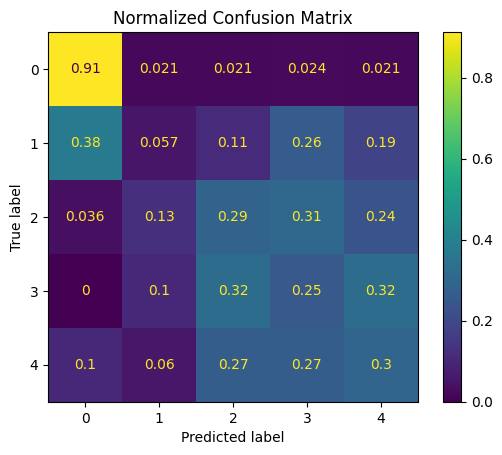

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       331
           1       0.11      0.06      0.07        53
           2       0.24      0.29      0.26        55
           3       0.21      0.25      0.23        59
           4       0.29      0.30      0.29        67

    accuracy                           0.63       565
   macro avg       0.35      0.36      0.35       565
weighted avg       0.62      0.63      0.63       565

In total 209 mistakes out of 565 samples


100%|██████████| 209/209 [00:00<00:00, 8266.78it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 4
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

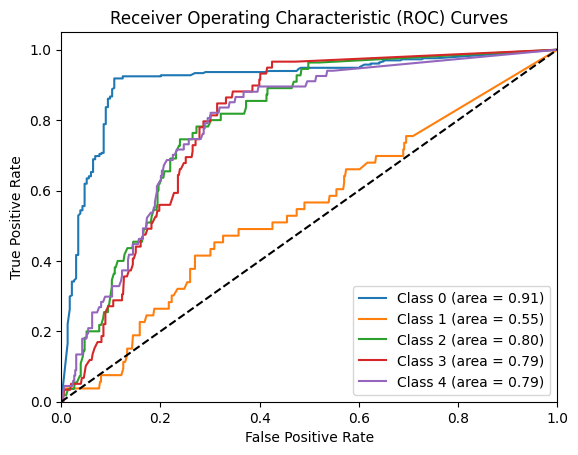

In [19]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_rf.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)

# ROC Curve
y_test_bin = label_binarize(y_test, classes=class_names)
y_pred_prob = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering using SVM (with Grid Search)

Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score: nan
Accuracy: 0.6654867256637168
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3


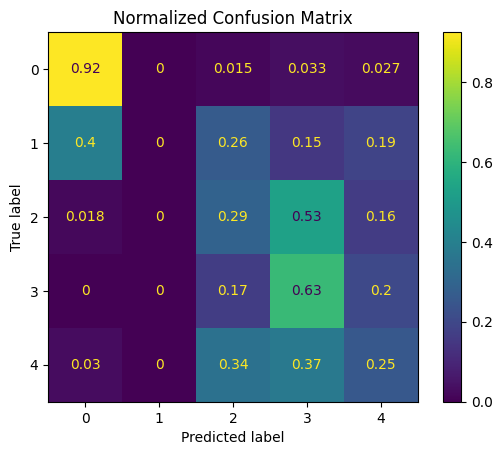

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       331
           1       0.00      0.00      0.00        53
           2       0.24      0.29      0.26        55
           3       0.34      0.63      0.44        59
           4       0.30      0.25      0.27        67

    accuracy                           0.67       565
   macro avg       0.36      0.42      0.38       565
weighted avg       0.64      0.67      0.65       565



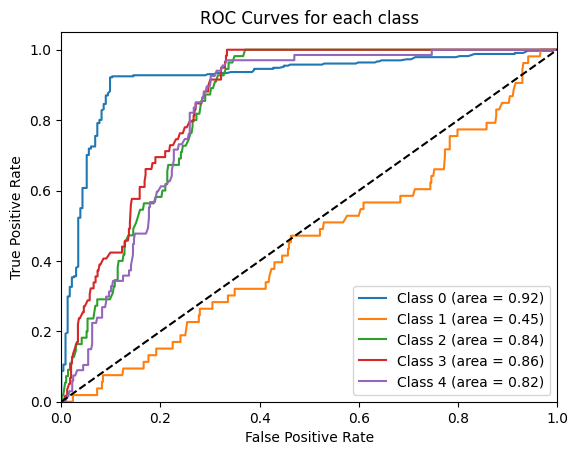

In total 189 mistakes out of 565 samples


100%|██████████| 189/189 [00:00<00:00, 9598.76it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 3
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with SVC
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_samples')
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
#joblib.dump(best_model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_svc_best.pkl')

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Cost-sensitive SVM

Best parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best score: 0.6272678217530366
Accuracy: 0.6407079646017699
Given features: 
     Map Killer  Nb Finished generators
1112  SH  Myers                       5
Predicted number of survivors escaping through exit gates for this round: 2
Actual number of survivors escaping through exit gates for this round: 3


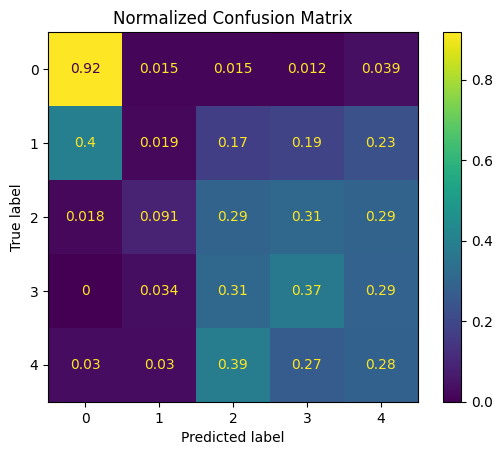

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       331
           1       0.07      0.02      0.03        53
           2       0.22      0.29      0.25        55
           3       0.31      0.37      0.34        59
           4       0.25      0.28      0.26        67

    accuracy                           0.64       565
   macro avg       0.35      0.38      0.36       565
weighted avg       0.63      0.64      0.63       565



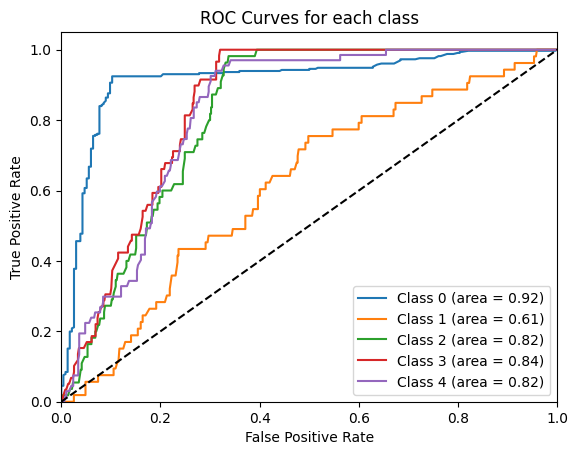

In total 203 mistakes out of 565 samples


100%|██████████| 203/203 [00:00<00:00, 9176.72it/s]

Mistake 1:
Features: 
Map                          SH
Killer                    Myers
Nb Finished generators        5
Name: 1112, dtype: object
Actual: 3, Predicted: 2
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 4
--------------------------------------------------
Mistake 3:
Features: 
Map                          AVW
Killer                    Artist
Nb Finished generators         5
Name: 2645, dtype: object
Actual: 2, Predicted: 4
--------------------------------------------------
Mistake 4:
Features: 
Map                           OR
Killer                    Blight
Nb Finished generators         5
Name: 1126, dtype: object
Actual: 4, Predicted: 3
--------------------------------------------------
Mistake 5:
Features: 
Map                            BWS
Killer                    Huntress
Nb Finished gener

In [9]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Define the model pipeline with cost-sensitive SVC
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, class_weight='balanced'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = best_model.predict(example)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
# import joblib
# joblib.dump(best_model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc_svc_cost_sensitive.pkl')

# ROC Curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in class_names:
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in class_names:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class')
plt.legend(loc="lower right")
plt.show()

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Binary Classification : Win or Loss (using SVM and grid search). Killer DC filtered and exit gates only

Accuracy: 0.8884955752212389
Given features: 
     Map Killer  Nb Finished generators Season   SBMM
1112  SH  Myers                       5    May  False
Predicted win (0: Killer, 1: Survivors) for this round: 1
Actual win (0: Killer, 1: Survivors) for this round: 1


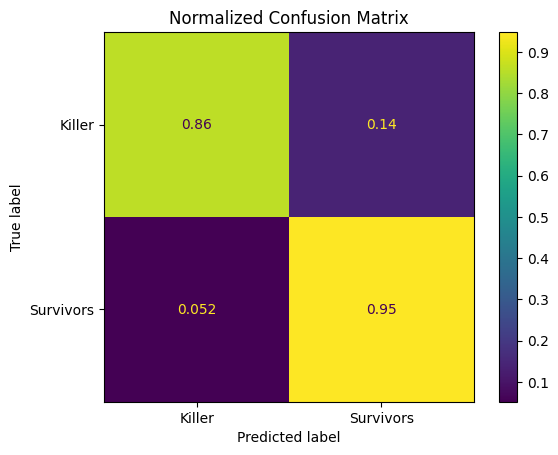

Classification Report:
              precision    recall  f1-score   support

      Killer       0.97      0.86      0.91       373
   Survivors       0.77      0.95      0.85       192

    accuracy                           0.89       565
   macro avg       0.87      0.90      0.88       565
weighted avg       0.90      0.89      0.89       565

In total 63 mistakes out of 565 samples


100%|██████████| 63/63 [00:00<00:00, 8663.36it/s]

Mistake 1:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Season                    November
SBMM                          True
Name: 2377, dtype: object
Actual: 0, Predicted: 1
--------------------------------------------------
Mistake 2:
Features: 
Map                                AVW
Killer                    Deathslinger
Nb Finished generators               5
Season                          August
SBMM                              True
Name: 1591, dtype: object
Actual: 0, Predicted: 1
--------------------------------------------------
Mistake 3:
Features: 
Map                                MCM
Killer                    Pyramid Head
Nb Finished generators               4
Season                          August
SBMM                              True
Name: 1763, dtype: object
Actual: 1, Predicted: 0
--------------------------------------------------
Mistake 4:
Features: 
Map                             SH
Killer   

In [8]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: win for survivors (1) or win for killer (0)
data['Win (S)'] = np.where(data['Nb Escaped Survivors'] <= 1, 0, 1)

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'Win (S)'])
target = data['Win (S)']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), features.select_dtypes(include=['number']).columns.tolist())
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Define the hyperparameters grid for SVC
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'linear']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

##############################
### maybe other scoring??? ###
##############################

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction
example = X_test.iloc[0:1]
predicted_win = best_model.predict(example)
actual_win = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted win (0: Killer, 1: Survivors) for this round: {predicted_win[0]}')
print(f'Actual win (0: Killer, 1: Survivors) for this round: {actual_win}')

# Confusion Matrix
class_names = ['Killer', 'Survivors']
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=class_names))

# Save the best model
# import joblib
# joblib.dump(best_model, 'dbd_winner_prediction_model_no_killer_dc_svm.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


In [6]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: win for killer (0) or win for survivors (1)
data['Win'] = np.where(data['Nb Escaped Survivors'] <= 1, 0, 1)
data.head()

,Map,Killer,Nb Finished generators,Nb Escaped Survivors,Comments,Nb Hatch escapes,Season,SBMM,Win
0,BAP,Deathslinger,5,4,NaN,0,February,False,1
1,MCM,Cannibal,2,0,NaN,0,February,False,0
2,SH,Huntress,5,4,Farm,0,February,False,1
3,CF,Myers,3,0,Mori,0,February,False,0
4,AVW,Hillbilly,5,4,1 hatch,1,February,False,1


PCA

Add performance analysis

Correlation analysis for seasons/SBMM